# Предсказание цен автомобилей на основании объявлений о продаже в Красноярском крае
## Ход работы
### Парсинг данных
Парсинг выполнялся с сервиса Drom.ru при помощи библиотеки Selenium. Вся информация сохранена в файле cars.csv. Парсер находится в папке parser.
### Предобработка данных

In [103]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import seaborn as sns

In [104]:
df = pd.read_csv("parser/cars.csv", index_col="id")
df

,brand,model,price,year,transmission,body,color,steering_wheel_pos,generation,mileage,engine_power,fuel_type,engine_capacity,wd,documents_cond,drivers_count,was_driven_by_legal_person,is_under_credit,description_len,without_mileage_in_RF
id,,,,,,,,,,,,,,,,,,,,
0,Toyota,Auris,1019000,2008,робот,хэтчбек 5 дв.,белый,левый,1 поколение,165000,124,бензин,1.6,передний,Характеристики совпадают с ПТС,3.0,True,True,1019.0,NaN
1,Toyota,Nadia,797000,2002,АКПП,-,серебристый,правый,"1 поколение, рестайлинг",344000,152,бензин,2.0,передний,NaN,NaN,NaN,NaN,3336.0,NaN
2,Lexus,LX570,3687000,2011,АКПП,-,серый,левый,3 поколение,182000,367,бензин,5.7,4WD,Характеристики совпадают с ПТС,2.0,False,True,NaN,NaN
3,Toyota,Land Cruiser Prado,3688000,2014,АКПП,джип/suv 5 дв.,черный,левый,"4 поколение, рестайлинг",245000,173,дизель,3.0,4WD,Характеристики совпадают с ПТС,4.0,False,True,NaN,NaN
4,Лада,Веста,999000,2019,механика,седан,белый,левый,1 поколение,105020,106,бензин,1.6,передний,Характеристики совпадают с ПТС,2.0,True,True,1100.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,Лада,Калина,378000,2012,механика,универсал,синий,левый,1 поколение,234000,81,бензин,1.6,передний,Характеристики совпадают с ПТС,2.0,False,True,NaN,NaN
342,Лада,Гранта,473000,2019,механика,седан,белый,левый,"1 поколение, рестайлинг",20000,87,бензин,1.6,передний,Характеристики совпадают с ПТС,1.0,False,False,NaN,NaN
343,Лада,2114 Самара,320000,2007,механика,хэтчбек 5 дв.,серый,левый,1 поколение,280000,80,бензин,1.6,передний,Характеристики совпадают с ПТС,3.0,False,False,NaN,NaN


<Axes: >

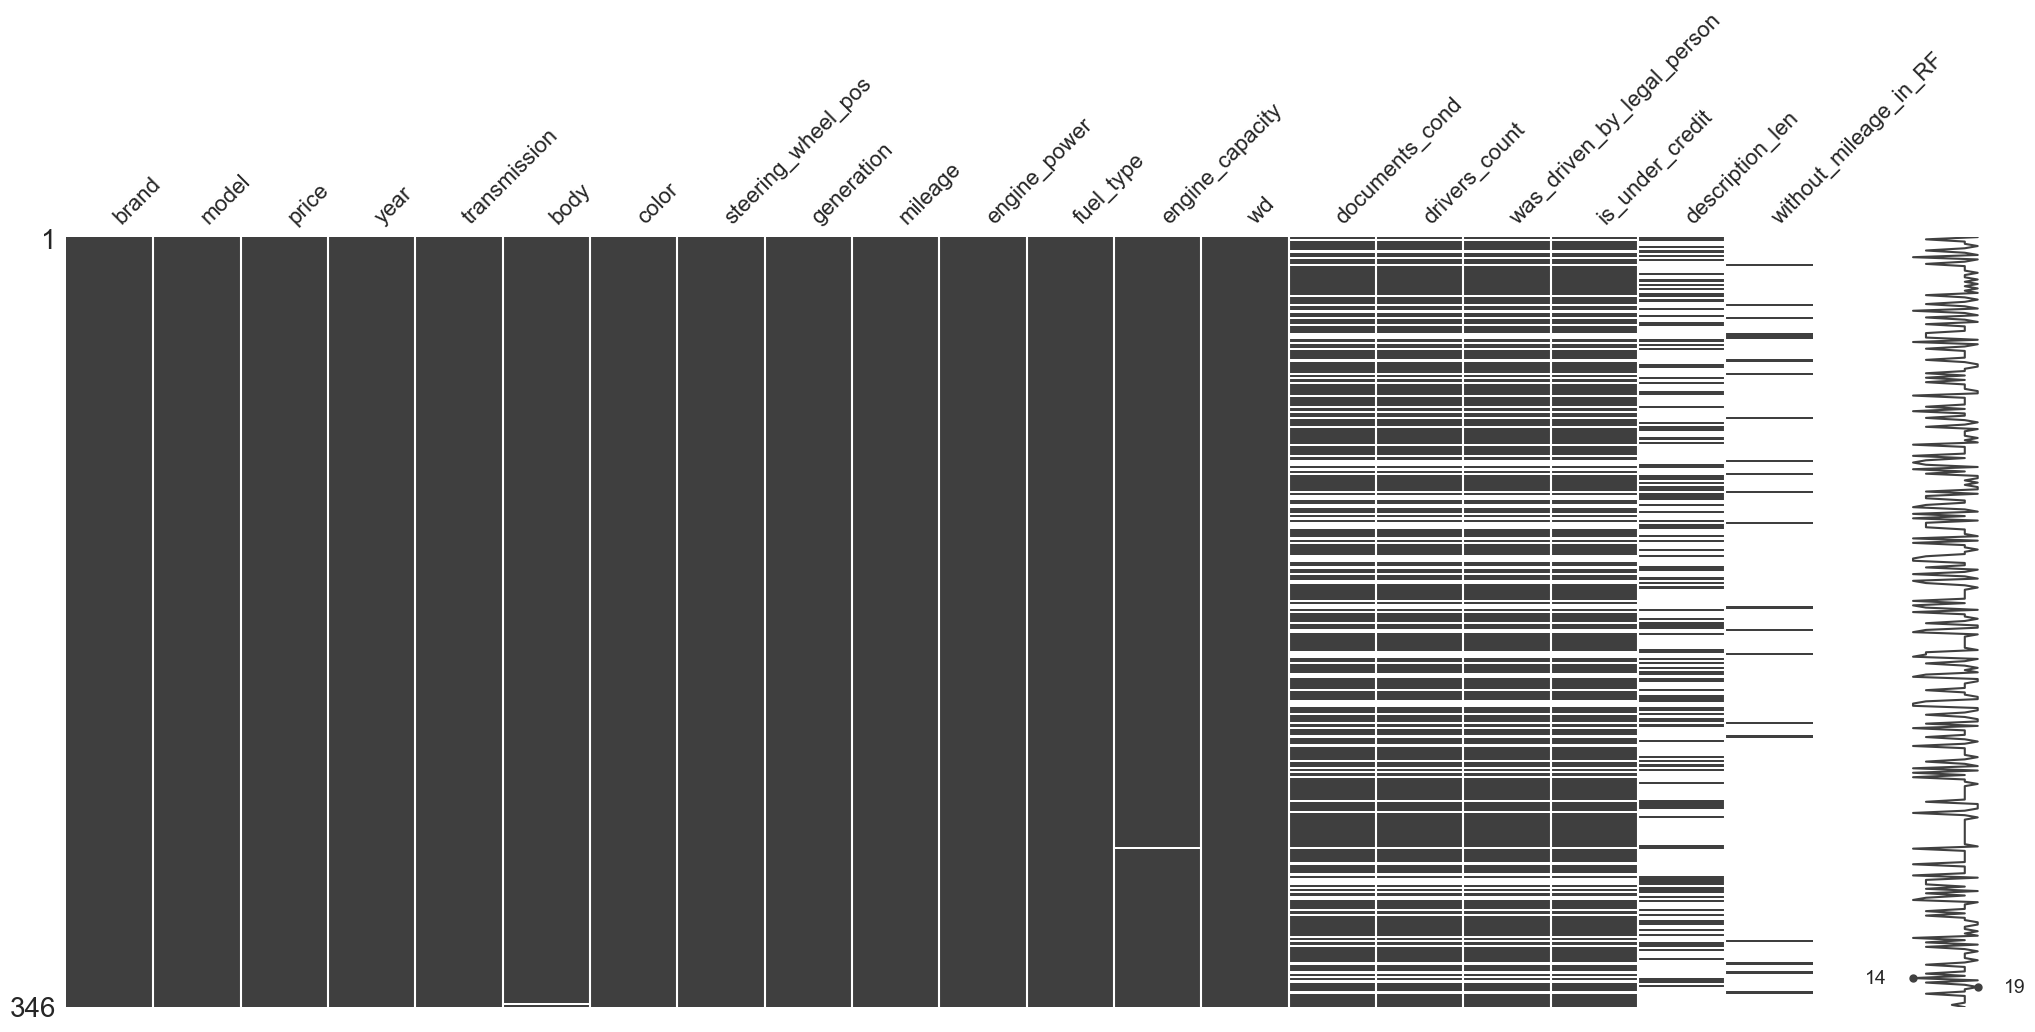

In [105]:
from missingno import matrix

matrix(df)

In [60]:
def prepare(data: pd.DataFrame) -> pd.DataFrame:
    data.fillna({
        "body": "-",
        "was_driven_by_legal_person": False,
        "is_under_credit": False,
        "without_mileage_in_RF": False,
        "description_len": 0,
    }, inplace=True)
    data["body"] = data["body"].replace("-", np.nan)
    documents = data["documents_cond"]
    data = data.drop("documents_cond", axis=1)
    data["is_documents_ok"] = documents == "Характеристики совпадают с ПТС"
    
    data.drop(["model", "generation"], axis=1, inplace=True)
    return data


def prepare_to_learn_df(data: pd.DataFrame) -> pd.DataFrame:
    data = data.copy()
    
    encoder = OneHotEncoder()  # Используем OneHotEncoder, потому что body - категориальная не упорядоченная переменная
    columns_to_encode = ["transmission", "fuel_type", "wd"]
    encoded = encoder.fit_transform(data[columns_to_encode])
    encoded = pd.DataFrame(encoded.toarray(),
                           columns=encoder.get_feature_names_out(columns_to_encode))
    data = pd.concat([data, encoded], axis=1)
    data.drop(columns_to_encode, axis=1, inplace=True)
    
    return data


def prepare_to_check_df(data: pd.DataFrame) -> pd.DataFrame:
    data = prepare(data.copy())
    
    encoder = LabelEncoder()
    columns_to_encode = ["body", "brand", "steering_wheel_pos", "transmission", "color", "fuel_type", "wd"]
    for col in columns_to_encode:
        data[col] = encoder.fit_transform(data[col])
    
    knn_imputer = KNNImputer(n_neighbors=5)
    data["drivers_count"] = knn_imputer.fit_transform(data[["drivers_count"]])
    data["drivers_count"] = data["drivers_count"].round().astype(int)
    
    return data

In [61]:
df

,brand,model,price,year,transmission,body,color,steering_wheel_pos,generation,mileage,engine_power,fuel_type,engine_capacity,wd,documents_cond,drivers_count,was_driven_by_legal_person,is_under_credit,description_len,without_mileage_in_RF
id,,,,,,,,,,,,,,,,,,,,
0,Toyota,Auris,1019000,2008,робот,хэтчбек 5 дв.,белый,левый,1 поколение,165000,124,бензин,1.6,передний,Характеристики совпадают с ПТС,3.0,True,True,1019.0,NaN
1,Toyota,Nadia,797000,2002,АКПП,-,серебристый,правый,"1 поколение, рестайлинг",344000,152,бензин,2.0,передний,NaN,NaN,NaN,NaN,3336.0,NaN
2,Lexus,LX570,3687000,2011,АКПП,-,серый,левый,3 поколение,182000,367,бензин,5.7,4WD,Характеристики совпадают с ПТС,2.0,False,True,NaN,NaN
3,Toyota,Land Cruiser Prado,3688000,2014,АКПП,джип/suv 5 дв.,черный,левый,"4 поколение, рестайлинг",245000,173,дизель,3.0,4WD,Характеристики совпадают с ПТС,4.0,False,True,NaN,NaN
4,Лада,Веста,999000,2019,механика,седан,белый,левый,1 поколение,105020,106,бензин,1.6,передний,Характеристики совпадают с ПТС,2.0,True,True,1100.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,Лада,Калина,378000,2012,механика,универсал,синий,левый,1 поколение,234000,81,бензин,1.6,передний,Характеристики совпадают с ПТС,2.0,False,True,NaN,NaN
342,Лада,Гранта,473000,2019,механика,седан,белый,левый,"1 поколение, рестайлинг",20000,87,бензин,1.6,передний,Характеристики совпадают с ПТС,1.0,False,False,NaN,NaN
343,Лада,2114 Самара,320000,2007,механика,хэтчбек 5 дв.,серый,левый,1 поколение,280000,80,бензин,1.6,передний,Характеристики совпадают с ПТС,3.0,False,False,NaN,NaN


In [62]:
tmp = prepare_to_check_df(df)
corr_matrix = tmp.corr()
corr_matrix

C:\Users\2004m\AppData\Local\Temp\ipykernel_9100\3161807378.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna({


,brand,price,year,transmission,body,color,steering_wheel_pos,mileage,engine_power,fuel_type,engine_capacity,wd,drivers_count,was_driven_by_legal_person,is_under_credit,description_len,without_mileage_in_RF,is_documents_ok
brand,1.000000,-0.027741,-0.000962,0.069312,-0.260460,0.004578,0.035472,0.100908,-0.082141,0.034775,0.088698,-0.040951,-0.104128,-0.019354,0.019212,0.036223,-0.051857,0.012527
price,-0.027741,1.000000,0.407861,-0.267317,-0.160913,0.040599,-0.188632,-0.300204,0.679327,0.234200,0.550394,-0.383447,-0.145115,-0.055851,-0.043474,0.078418,0.020608,-0.047061
year,-0.000962,0.407861,1.000000,0.075392,-0.021976,-0.162183,-0.174858,-0.735696,0.087750,0.164903,-0.014366,-0.074612,-0.414965,-0.096643,-0.053220,-0.020274,0.207406,-0.059467
transmission,0.069312,-0.267317,0.075392,1.000000,0.196956,-0.089282,0.104393,-0.090650,-0.420599,-0.051297,-0.381966,0.182229,-0.010162,-0.123237,-0.117180,0.041271,0.112725,-0.114918
body,-0.260460,-0.160913,-0.021976,0.196956,1.000000,-0.066059,0.291634,-0.012810,-0.141153,-0.072549,-0.248189,0.118579,-0.057857,-0.213841,-0.277595,0.087029,0.136591,-0.297316
color,0.004578,0.040599,-0.162183,-0.089282,-0.066059,1.000000,-0.033882,0.168183,0.107414,-0.009570,0.128178,-0.054519,0.114638,-0.033692,-0.011278,-0.059111,0.022581,0.000747
steering_wheel_pos,0.035472,-0.188632,-0.174858,0.104393,0.291634,-0.033882,1.000000,0.070862,-0.358106,0.066616,-0.345986,0.222659,-0.060454,-0.568089,-0.788599,0.045712,0.348104,-0.805267
mileage,0.100908,-0.300204,-0.735696,-0.090650,-0.012810,0.168183,0.070862,1.000000,-0.006245,-0.047943,0.103940,-0.026102,0.364772,0.067585,0.155437,-0.037226,-0.223680,0.162417
engine_power,-0.082141,0.679327,0.087750,-0.420599,-0.141153,0.107414,-0.358106,-0.006245,1.000000,0.116730,0.886283,-0.524784,0.046050,0.060318,0.191552,-0.031528,-0.097306,0.194223
fuel_type,0.034775,0.234200,0.164903,-0.051297,-0.072549,-0.009570,0.066616,-0.047943,0.116730,1.000000,0.183578,-0.236412,-0.037841,-0.089361,-0.119043,0.111676,0.072972,-0.147886


In [63]:
price_corr = corr_matrix["price"]
threshold = 0.2  # Устанавливаем минимальный порог корреляции, при котором не будем брать признак
weak_correlated = price_corr[abs(price_corr) < threshold].index
weak_correlated

Index(['brand', 'body', 'color', 'steering_wheel_pos', 'drivers_count',
       'was_driven_by_legal_person', 'is_under_credit', 'description_len',
       'without_mileage_in_RF', 'is_documents_ok'],
      dtype='object')

In [64]:
df = prepare(df).drop(weak_correlated, axis=1)

C:\Users\2004m\AppData\Local\Temp\ipykernel_9100\3161807378.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data.fillna({


In [65]:
df

,price,year,transmission,mileage,engine_power,fuel_type,engine_capacity,wd
id,,,,,,,,
0,1019000,2008,робот,165000,124,бензин,1.6,передний
1,797000,2002,АКПП,344000,152,бензин,2.0,передний
2,3687000,2011,АКПП,182000,367,бензин,5.7,4WD
3,3688000,2014,АКПП,245000,173,дизель,3.0,4WD
4,999000,2019,механика,105020,106,бензин,1.6,передний
...,...,...,...,...,...,...,...,...
341,378000,2012,механика,234000,81,бензин,1.6,передний
342,473000,2019,механика,20000,87,бензин,1.6,передний
343,320000,2007,механика,280000,80,бензин,1.6,передний


In [66]:
cool_cols = df.columns
cool_cols

Index(['price', 'year', 'transmission', 'mileage', 'engine_power', 'fuel_type',
       'engine_capacity', 'wd'],
      dtype='object')

Как мы видим, подходят не все колонки.

In [67]:
df = prepare_to_learn_df(df)
df

,price,year,mileage,engine_power,engine_capacity,transmission_АКПП,transmission_автомат,transmission_вариатор,transmission_механика,transmission_робот,fuel_type_бензин,fuel_type_гибрид,fuel_type_дизель,fuel_type_электро,wd_4WD,wd_задний,wd_передний
0,1019000,2008,165000,124,1.6,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,797000,2002,344000,152,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,3687000,2011,182000,367,5.7,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
3,3688000,2014,245000,173,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,999000,2019,105020,106,1.6,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341,378000,2012,234000,81,1.6,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
342,473000,2019,20000,87,1.6,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
343,320000,2007,280000,80,1.6,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
344,165000,2010,99000,72,1.6,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


### Графический анализ

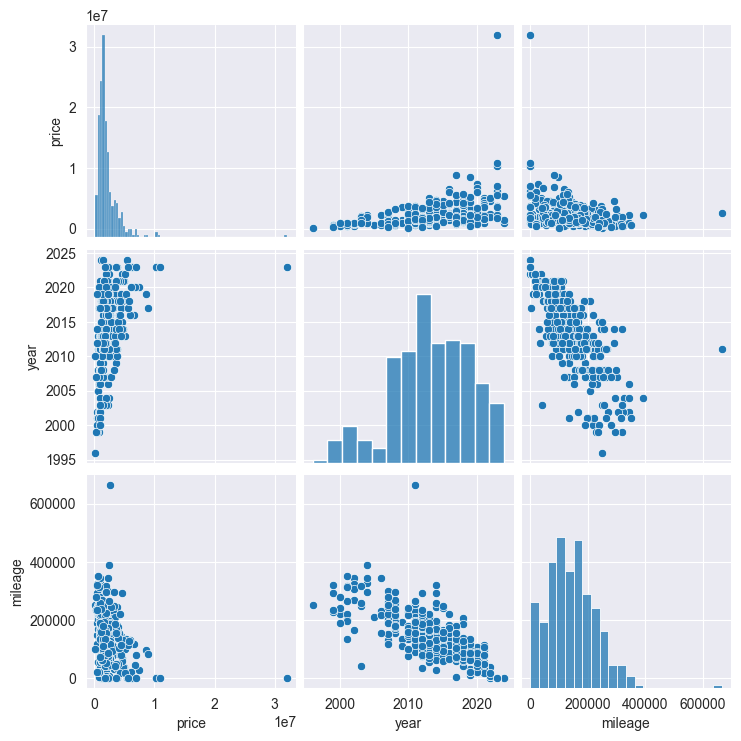

In [68]:
sns.pairplot(df[["price", "year", "mileage"]])

На графиках мы видим выбросы, которые необходимо устранить
### Устранение выбросов

In [69]:
len(df)

346

In [70]:
cols = ["year", "mileage", "price"]
for col in cols:
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.75)
    iqr = q3 - q1
    df = df[(df[col] >= q1 - 1.5 * iqr) & (df[col] <= q3 + 1.5 * iqr)]


In [71]:
len(df)

314

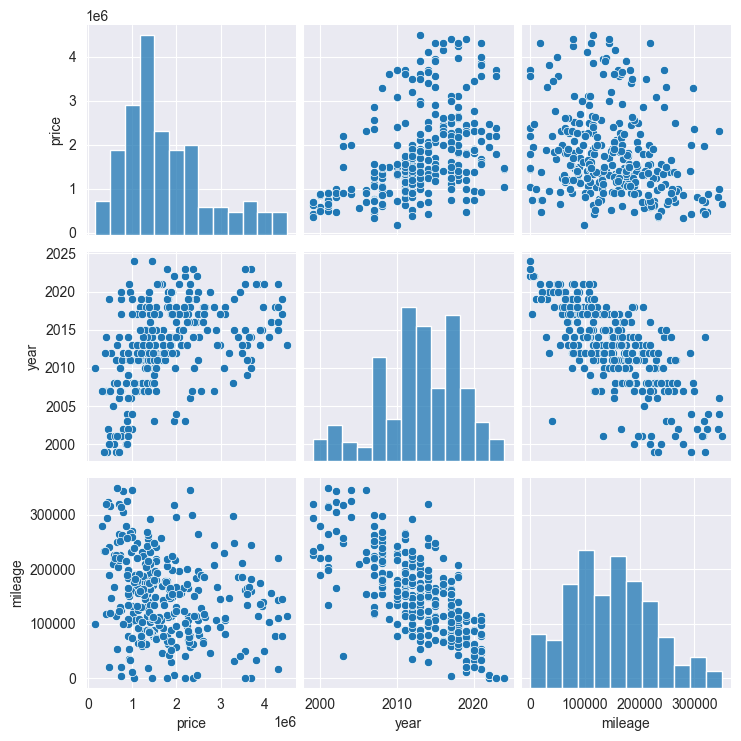

In [72]:
sns.pairplot(df[["price", "year", "mileage"]])

Баланс в данных восстановлен, можно приступать к обучению модели
### Обучение модели
#### Линейная регрессия

In [73]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

Разделим выборку на обучающую и тестовую

In [74]:
X = df.drop("price", axis=1)
y = df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [75]:
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

y_pred = lin_reg.predict(X_test)
lin_mse = mean_squared_error(y_test, y_pred)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

615021.2313746377

In [76]:
lin_reg.score(X_test, y_test)


0.6384653588248943

Видим, что линейная регрессия показывает себя не очень хорошо. Попробуем другие модели
#### Случайный лес

In [77]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

param_grid = {
    'n_estimators': [50, 100, 200],  # количество деревьев в лесу
    'max_depth': [None, 10, 20, 30],  # максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # минимальное количество выборок, необходимых для разделения внутреннего узла
    'min_samples_leaf': [1, 2, 4],  # минимальное количество выборок, необходимых для листового узла
    'bootstrap': [True, False]  # метод для выборки подмножеств для обучения каждого базового ученика
}

forest_reg = RandomForestRegressor()

# Инициализация RandomizedSearchCV
search = RandomizedSearchCV(estimator=forest_reg, param_distributions=param_grid, n_iter=15, n_jobs=-1)

# Подгонка GridSearchCV к данным
# grid_search.fit(X_train, y_train)
search.fit(X_train, y_train)

# Получение лучших параметров
search.best_params_

{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 10,
 'bootstrap': True}

In [78]:
best_forest = search.best_estimator_
y_pred = best_forest.predict(X_test)
forest_mse = mean_squared_error(y_test, y_pred)
forest_rmse = np.sqrt(forest_mse)
forest_rmse

541281.84103606

In [79]:
best_forest.score(X_test, y_test)

0.7199622273878348

Видим, что случайный лес показывает себя лучше линейной регрессии, пробуем дальше
#### Градиентный бустинг

In [80]:
from sklearn.ensemble import GradientBoostingRegressor

param_grid = {
    'n_estimators': [50, 100, 200],  # количество деревьев в лесу
    'max_depth': [3, 5, 7],  # максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # минимальное количество выборок, необходимых для разделения внутреннего узла
    'min_samples_leaf': [1, 2, 4],  # минимальное количество выборок, необходимых для листового узла
}

grad_boost = GradientBoostingRegressor()

search = RandomizedSearchCV(estimator=grad_boost, param_distributions=param_grid, n_iter=15, n_jobs=-1)

# Подгонка GridSearchCV к данным
search.fit(X_train, y_train)

# Получение лучших параметров
search.best_params_

{'n_estimators': 100,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_depth': 3}

In [81]:
best_grad_boost = search.best_estimator_
y_pred = best_grad_boost.predict(X_test)
grad_boost_mse = mean_squared_error(y_test, y_pred)
grad_boost_rmse = np.sqrt(grad_boost_mse)
grad_boost_rmse

501291.50347339234

In [82]:
best_grad_boost.score(X_test, y_test)

0.7598125082549663

Продолжаем перебор
#### Дерево решений

In [83]:
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    'max_depth': [None, 10, 20, 30],  # максимальная глубина дерева
    'min_samples_split': [2, 5, 10],  # минимальное количество выборок, необходимых для разделения внутреннего узла
    'min_samples_leaf': [1, 2, 4],  # минимальное количество выборок, необходимых для листового узла
}

tree_reg = DecisionTreeRegressor()

search = RandomizedSearchCV(estimator=tree_reg, param_distributions=param_grid, n_iter=15, n_jobs=-1)

# Подгонка GridSearchCV к данным
search.fit(X_train, y_train)

# Получение лучших параметров
search.best_params_

{'min_samples_split': 10, 'min_samples_leaf': 1, 'max_depth': None}

In [84]:
best_tree = search.best_estimator_

y_pred = best_tree.predict(X_test)
tree_mse = mean_squared_error(y_test, y_pred)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

643529.0544264404

In [85]:
best_tree.score(X_test, y_test)

0.6041724498613943

Дерево решений, как и ожидалось, показывает себя хуже предшествующих моделей
#### Ridge, Lasso и Spline регрессия

In [86]:
from sklearn.linear_model import Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

param_grid = {
    'alpha': [0.1, 1, 10, 100, 300, 500, 1000]
}

ridge = Ridge()
lasso = Lasso()

search = RandomizedSearchCV(estimator=ridge, param_distributions=param_grid, n_iter=15, n_jobs=-1)
# Подгонка GridSearchCV к данным
search.fit(X_train, y_train)

# Получение лучших параметров
search.best_params_

D:\Projects\DromDataRegressor\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 7 is smaller than n_iter=15. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'alpha': 10}

In [87]:
best_ridge = search.best_estimator_

y_pred = best_ridge.predict(X_test)
ridge_mse = mean_squared_error(y_test, y_pred)
ridge_rmse = np.sqrt(ridge_mse)
ridge_rmse

611533.3463538997

In [88]:
best_ridge.score(X_test, y_test)

0.6425543741383393

In [89]:
search = RandomizedSearchCV(estimator=lasso, param_distributions=param_grid, n_iter=15, n_jobs=-1)

# Подгонка GridSearchCV к данным
search.fit(X_train, y_train)

# Получение лучших параметров
search.best_params_

D:\Projects\DromDataRegressor\.venv\Lib\site-packages\sklearn\model_selection\_search.py:320: UserWarning: The total space of parameters 7 is smaller than n_iter=15. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


{'alpha': 1000}

In [90]:
best_lasso = search.best_estimator_

y_pred = best_lasso.predict(X_test)
lasso_mse = mean_squared_error(y_test, y_pred)
lasso_rmse = np.sqrt(lasso_mse)
lasso_rmse

613980.0632629642

In [91]:
best_lasso.score(X_test, y_test)

0.639688405125003

In [92]:
from sklearn.pipeline import Pipeline

param_grid = {
    'r__alpha': [0.1, 1, 10, 100, 300, 500, 1000],
    'pf__degree': [2, 3, 4]
}

spline = Pipeline([
    ('pf', PolynomialFeatures()),
    ('r', Ridge())
])

# Инициализация GridSearchCV
search = RandomizedSearchCV(estimator=spline, param_distributions=param_grid, n_iter=15, n_jobs=-1)

search.fit(X_train, y_train)

# Получение лучших параметров 
search.best_params_

D:\Projects\DromDataRegressor\.venv\Lib\site-packages\sklearn\linear_model\_ridge.py:216: LinAlgWarning: Ill-conditioned matrix (rcond=2.83912e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


{'r__alpha': 1, 'pf__degree': 2}

In [93]:
best_spline = search.best_estimator_

y_pred = best_spline.predict(X_test)
spline_mse = mean_squared_error(y_test, y_pred)
spline_rmse = np.sqrt(spline_mse)
spline_rmse

607087.3098405777

In [94]:
best_spline.score(X_test, y_test)

0.64773296093689

In [95]:
results = pd.DataFrame({
    "model": ["Linear Regression", "Random Forest", "Gradient Boosting", "Decision Tree", "Ridge", "Lasso", "Spline"],
    "RMSE": [lin_rmse, forest_rmse, grad_boost_rmse, tree_rmse, ridge_rmse, lasso_rmse, spline_rmse],
    "R^2": [lin_reg.score(X_test, y_test), best_forest.score(X_test, y_test), best_grad_boost.score(X_test, y_test), best_tree.score(X_test, y_test), best_ridge.score(X_test, y_test), best_lasso.score(X_test, y_test), best_spline.score(X_test, y_test)]
})
results

,model,RMSE,R^2
0,Linear Regression,615021.231375,0.638465
1,Random Forest,541281.841036,0.719962
2,Gradient Boosting,501291.503473,0.759813
3,Decision Tree,643529.054426,0.604172
4,Ridge,611533.346354,0.642554
5,Lasso,613980.063263,0.639688
6,Spline,607087.309841,0.647733


### Вывод
Исходя из проведённых испытаний, можно сделать вывод, что наилучшим образом себя показывает модель градиентного бустинга. Она показала наименьшую среднеквадратичную ошибку и наибольший коэффициент детерминации.

In [96]:
X_train

,year,mileage,engine_power,engine_capacity,transmission_АКПП,transmission_автомат,transmission_вариатор,transmission_механика,transmission_робот,fuel_type_бензин,fuel_type_гибрид,fuel_type_дизель,fuel_type_электро,wd_4WD,wd_задний,wd_передний
133,2011,196000,169,2.5,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
119,2017,165000,146,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
157,2016,114500,150,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
88,2019,116000,144,2.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
111,2012,147431,98,1.6,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2013,212000,173,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
86,2007,225000,152,2.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
126,2017,109000,79,1.2,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
298,2017,178000,114,1.6,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


### Проверка на новых данных

In [97]:
cool_cols

Index(['price', 'year', 'transmission', 'mileage', 'engine_power', 'fuel_type',
       'engine_capacity', 'wd'],
      dtype='object')

In [98]:
test_df = pd.DataFrame({"id": 1, "year": 2013, "mileage": 166900, "engine_power": 82, "engine_capacity": 1.6, "transmission": "механика", "fuel_type": "бензин", "wd": "передний"}, index=[0])
test_df = prepare_to_learn_df(test_df)
for col in X.columns:
    if col not in test_df.columns:
        test_df[col] = 0
test_df.drop("id", axis=1, inplace=True)
test_df = test_df.reindex(columns=X.columns)
test_df

,year,mileage,engine_power,engine_capacity,transmission_АКПП,transmission_автомат,transmission_вариатор,transmission_механика,transmission_робот,fuel_type_бензин,fuel_type_гибрид,fuel_type_дизель,fuel_type_электро,wd_4WD,wd_задний,wd_передний
0,2013,166900,82,1.6,0,0,0,1.0,0,1.0,0,0,0,0,0,1.0


In [99]:
best_grad_boost.predict(test_df)

array([528228.31364609])

### Визуализация лучшей модели

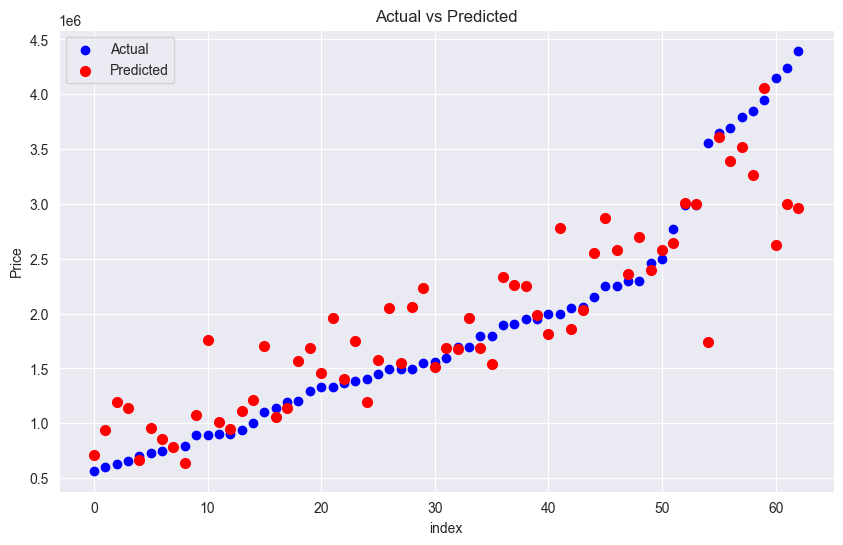

In [100]:
import matplotlib.pyplot as plt

# Предсказываем значения
y_pred = best_grad_boost.predict(X_test)

# Создаем график
plt.figure(figsize=(10, 6))

# Рисуем истинные значения в виде точек
tmp = zip(y_test, y_pred)
tmp = sorted(tmp, key=lambda x: x[0])
_y_test, y_pred = zip(*tmp)
plt.scatter(range(len(y_test)), _y_test, color='blue', label='Actual')

# Рисуем предсказанные значения в виде линии
plt.scatter(range(len(y_test)), y_pred, color='red', linewidth=2, label='Predicted')

plt.title('Actual vs Predicted')
plt.xlabel('index')
plt.ylabel('Price')
plt.legend()
plt.show()